Looking to predict GPS location (lat/lon) using camera images, still trying to see what is the best measure to identify performance of the model.

In [108]:
DIR = 'Street View Images/'
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data
import warnings

warnings.filterwarnings("ignore", category=UserWarning) 

Getting the data ready. Need to match up the data from   '../input/StreetViewGPS.csv'   with the images in the  
  '../input/Street View Images/'  .

In [109]:
files = [os.path.join(DIR, fname)
        for fname in os.listdir(DIR)]
files = files[:]
files = sorted(files)

In [110]:
imgs = [plt.imread(fname)[..., :3] for fname in files]
imgs = [resize(img_i, (200, 200)) for img_i in imgs]
imgs = np.array(imgs).astype(np.float32)
print("Number of images", len(imgs))

Number of images 113


In [111]:
gps_coords = pd.read_csv('StreetViewGPS.csv', error_bad_lines=False)
print("Number of GPS coords", len(gps_coords))

Number of GPS coords 104


b'Skipping line 64: expected 6 fields, saw 7\nSkipping line 65: expected 6 fields, saw 7\nSkipping line 66: expected 6 fields, saw 7\nSkipping line 67: expected 6 fields, saw 7\nSkipping line 68: expected 6 fields, saw 7\nSkipping line 69: expected 6 fields, saw 7\nSkipping line 70: expected 6 fields, saw 7\nSkipping line 75: expected 6 fields, saw 7\nSkipping line 80: expected 6 fields, saw 7\n'


In [112]:
imgs = np.delete(imgs, (64, 65, 66, 67, 68, 69, 70, 75, 80), axis=0)

In [113]:
print("Number of images", len(imgs))
print("Number of GPS coords", len(gps_coords))

Number of images 104
Number of GPS coords 104


GPS data and corresponding image:

 lat                     47.383732
 lon                     8.546212
 yaw_degree            331.600000
 tilt_yaw_degree      -158.470000
 tilt_pitch degree       0.090000
 auxiliary variable      1.000000
Name: 103, dtype: float64


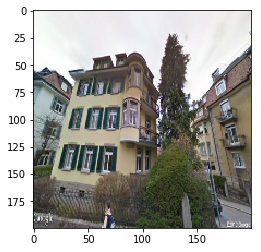

In [114]:
print("GPS data and corresponding image:\n\n", gps_coords.iloc[-1, :].T)
plt.imshow(imgs[-1])
plt.show()

In [115]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [116]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(2))

In [117]:
from keras import optimizers
model.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(lr=1e-4))

In [118]:
targets = pd.concat([gps_coords.iloc[:,0], gps_coords.iloc[:,1]], axis=1)
inputs = imgs

In [119]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
target_scaler = scaler.fit(targets)
targets = target_scaler.transform(targets)
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, random_state=5,
                                                   test_size=0.2)

In [120]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=40,
                              verbose=0, mode='auto')

In [121]:
history = model.fit(x_train, y_train, verbose=2, epochs=400, batch_size=5,
                   validation_data=(x_test, y_test))

Train on 83 samples, validate on 21 samples
Epoch 1/400
2s - loss: 3.4765 - val_loss: 0.3595
Epoch 2/400
0s - loss: 3.5842 - val_loss: 0.1319
Epoch 3/400
0s - loss: 2.6108 - val_loss: 0.3593
Epoch 4/400
0s - loss: 2.9146 - val_loss: 0.0936
Epoch 5/400
0s - loss: 3.1653 - val_loss: 0.4864
Epoch 6/400
0s - loss: 3.5353 - val_loss: 1.0310
Epoch 7/400
0s - loss: 2.8283 - val_loss: 0.1736
Epoch 8/400
0s - loss: 2.9479 - val_loss: 0.4842
Epoch 9/400
0s - loss: 2.7549 - val_loss: 0.2149
Epoch 10/400
0s - loss: 2.5091 - val_loss: 0.6572
Epoch 11/400
0s - loss: 2.7598 - val_loss: 0.4310
Epoch 12/400
0s - loss: 2.8966 - val_loss: 2.5211
Epoch 13/400
0s - loss: 2.6881 - val_loss: 1.8807
Epoch 14/400
0s - loss: 2.5627 - val_loss: 4.6168
Epoch 15/400
0s - loss: 1.7645 - val_loss: 3.0183
Epoch 16/400
0s - loss: 2.2704 - val_loss: 1.5160
Epoch 17/400
0s - loss: 2.5199 - val_loss: 0.3301
Epoch 18/400
0s - loss: 2.2950 - val_loss: 1.3422
Epoch 19/400
0s - loss: 2.7139 - val_loss: 0.6310
Epoch 20/400
0s

0s - loss: 0.4794 - val_loss: 0.1614
Epoch 164/400
0s - loss: 0.4709 - val_loss: 0.2136
Epoch 165/400
0s - loss: 0.4686 - val_loss: 0.1545
Epoch 166/400
0s - loss: 0.5201 - val_loss: 0.1561
Epoch 167/400
0s - loss: 0.4472 - val_loss: 0.1478
Epoch 168/400
0s - loss: 0.5282 - val_loss: 0.1731
Epoch 169/400
0s - loss: 0.4584 - val_loss: 0.2779
Epoch 170/400
0s - loss: 0.3994 - val_loss: 0.2121
Epoch 171/400
0s - loss: 0.4549 - val_loss: 0.1569
Epoch 172/400
0s - loss: 0.4464 - val_loss: 0.3158
Epoch 173/400
0s - loss: 0.3996 - val_loss: 0.1836
Epoch 174/400
0s - loss: 0.4366 - val_loss: 0.1920
Epoch 175/400
0s - loss: 0.4471 - val_loss: 0.1233
Epoch 176/400
0s - loss: 0.4217 - val_loss: 0.1883
Epoch 177/400
0s - loss: 0.4967 - val_loss: 0.1387
Epoch 178/400
0s - loss: 0.6097 - val_loss: 0.1883
Epoch 179/400
0s - loss: 0.4835 - val_loss: 0.1706
Epoch 180/400
0s - loss: 0.4030 - val_loss: 0.1353
Epoch 181/400
0s - loss: 0.4665 - val_loss: 0.1596
Epoch 182/400
0s - loss: 0.4259 - val_loss: 0

0s - loss: 0.1445 - val_loss: 0.0803
Epoch 325/400
0s - loss: 0.1642 - val_loss: 0.0699
Epoch 326/400
0s - loss: 0.1541 - val_loss: 0.0735
Epoch 327/400
0s - loss: 0.1470 - val_loss: 0.0518
Epoch 328/400
0s - loss: 0.1545 - val_loss: 0.0704
Epoch 329/400
0s - loss: 0.1574 - val_loss: 0.0591
Epoch 330/400
0s - loss: 0.1609 - val_loss: 0.0693
Epoch 331/400
0s - loss: 0.1661 - val_loss: 0.0535
Epoch 332/400
0s - loss: 0.1725 - val_loss: 0.0673
Epoch 333/400
0s - loss: 0.1786 - val_loss: 0.0575
Epoch 334/400
0s - loss: 0.1665 - val_loss: 0.1205
Epoch 335/400
0s - loss: 0.1412 - val_loss: 0.0990
Epoch 336/400
0s - loss: 0.1754 - val_loss: 0.0832
Epoch 337/400
0s - loss: 0.1448 - val_loss: 0.0917
Epoch 338/400
0s - loss: 0.1498 - val_loss: 0.1082
Epoch 339/400
0s - loss: 0.1403 - val_loss: 0.0886
Epoch 340/400
0s - loss: 0.1676 - val_loss: 0.0733
Epoch 341/400
0s - loss: 0.1955 - val_loss: 0.0628
Epoch 342/400
0s - loss: 0.1396 - val_loss: 0.1085
Epoch 343/400
0s - loss: 0.1447 - val_loss: 0

In [123]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


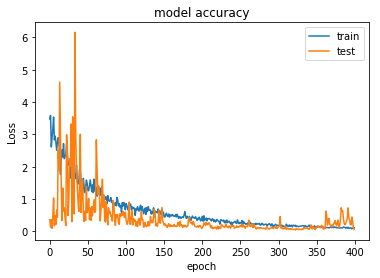

In [124]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [137]:
from sklearn.metrics import mean_squared_error
target_1 = targets[0].reshape(1,2)

In [138]:
pred = model.predict(np.reshape(imgs[-1], (1,200,200,3)))
pred = target_scaler.inverse_transform(pred)
target_1 = target_scaler.inverse_transform(target_1)
print("MSE: ", (mean_squared_error(target_1, pred)))

MSE:  1.00341917072e-07


Still some room for improvement, in real world terms the predictions are still far off, but is a good start.

In [140]:
comparison = np.concatenate((pred, target_1), axis=1)
comparison = pd.DataFrame(comparison)
comparison.columns = ['Predicted latitude', 'Predicted longitude', 'True latitude', 'True longitude']
comparison = pd.concat([comparison['Predicted latitude'], comparison['True latitude'], comparison['Predicted longitude'], comparison['True longitude']], axis=1)                     
comparison.head()

,Predicted latitude,True latitude,Predicted longitude,True longitude
0,47.383926,47.384345,8.545197,8.545037


In [75]:
imgs[1].shape

(200, 200, 3)